In [1]:
%matplotlib ipympl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from onix.data_tools import get_experiment_data
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
from tqdm import tqdm
import pprint
import pint
from onix.analysis.functions.optical_antihole_check import *

# PLOTTING OPTICAL SPECTRUM
### plot_antihole_data(data_numbers, normalize=True, fitit=False, errors=True, labels=None)
    - data number input: data_numbers as int, tuple, or list 
    - normalize: normalizes to monitors PD
    - fitit: fit to gaussian and plot fit
    - errors: include errorbars ------------> CHECK it seems too small
    - labels: select which labels to plot, e.g. labels=["rf"] only plots only rf labelled data
                   if labels is None: plots all data

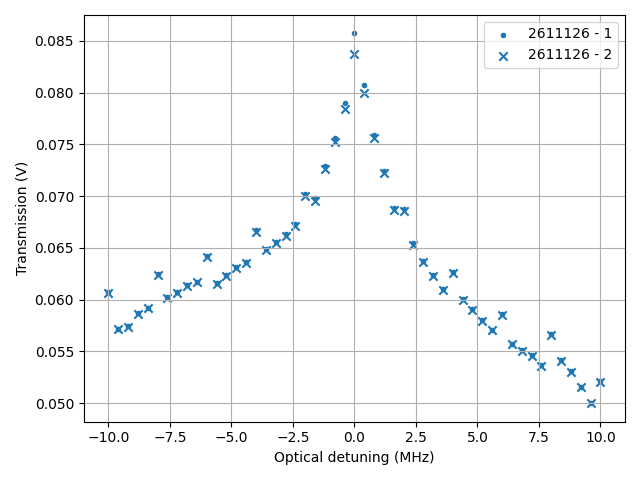

In [2]:
plot_antihole_data(2611126, normalize=False, fitit=False, errors=False, labels=None)

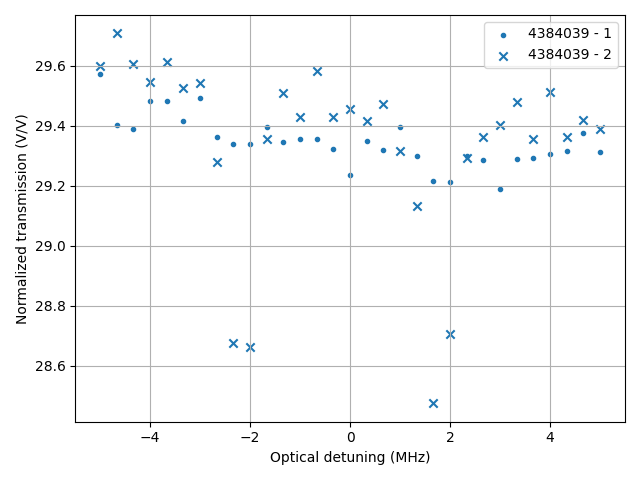

In [43]:
plot_antihole_data(4384039)

In [435]:
get_experiment_data(4382470)[0]["monitors_avg"][0]

array([0.00802053, 0.00879004, 0.0092219 , 0.00906333, 0.00831913,
       0.00916263, 0.00866797, 0.00891908, 0.00829931, 0.00844258,
       0.00900365, 0.00923346, 0.00912725, 0.0091436 , 0.00928618,
       0.00900455, 0.00804388, 0.0092101 , 0.00899935, 0.00809285,
       0.00930817, 0.00803328, 0.00915017, 0.00917981, 0.00896537,
       0.00925909, 0.00883322, 0.00940363, 0.00845912, 0.00895182])

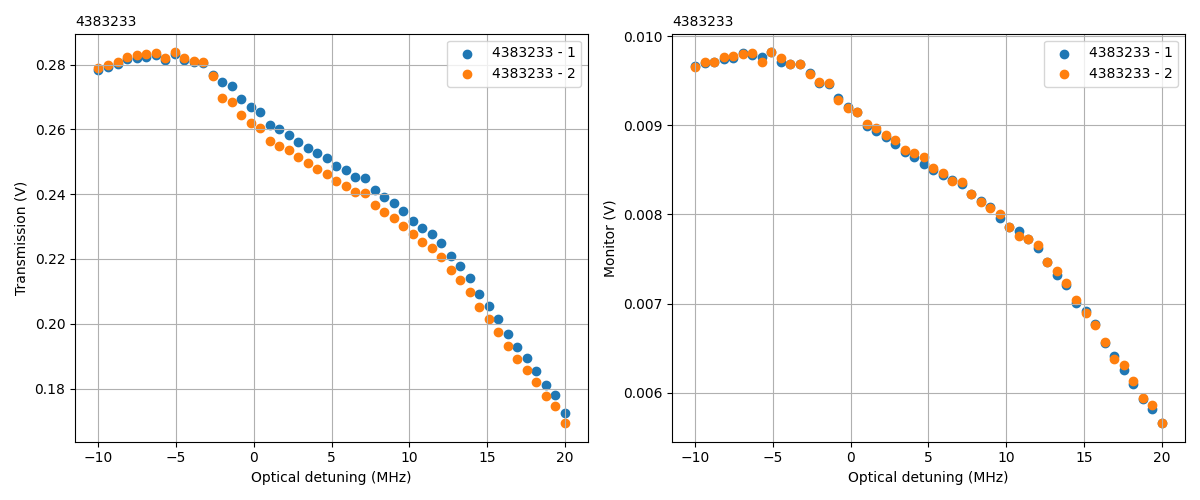

In [41]:
plot_raw_data(4383233)

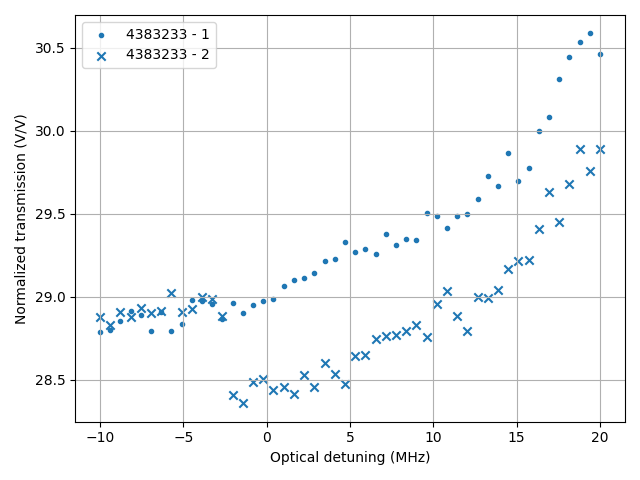

In [42]:
plot_antihole_data(4383233)

In [45]:
d, h = get_experiment_data(4383233)
h["params"]["chasm"]

{'scan': 10 <Unit('megahertz')>,
 'durations': 10 <Unit('millisecond')>,
 'ao_amplitude': 2000,
 'transitions': ['bb'],
 'repeats': 20,
 'detunings': 0 <Unit('megahertz')>}

/tmp/ipykernel_2092513/799552915.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


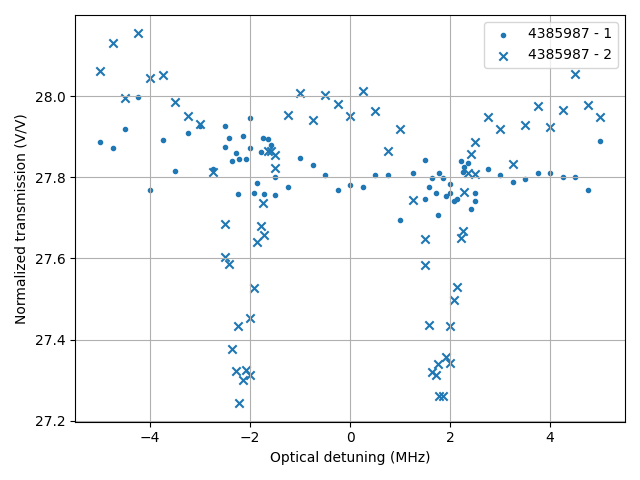

In [40]:
plot_antihole_data(4385987)

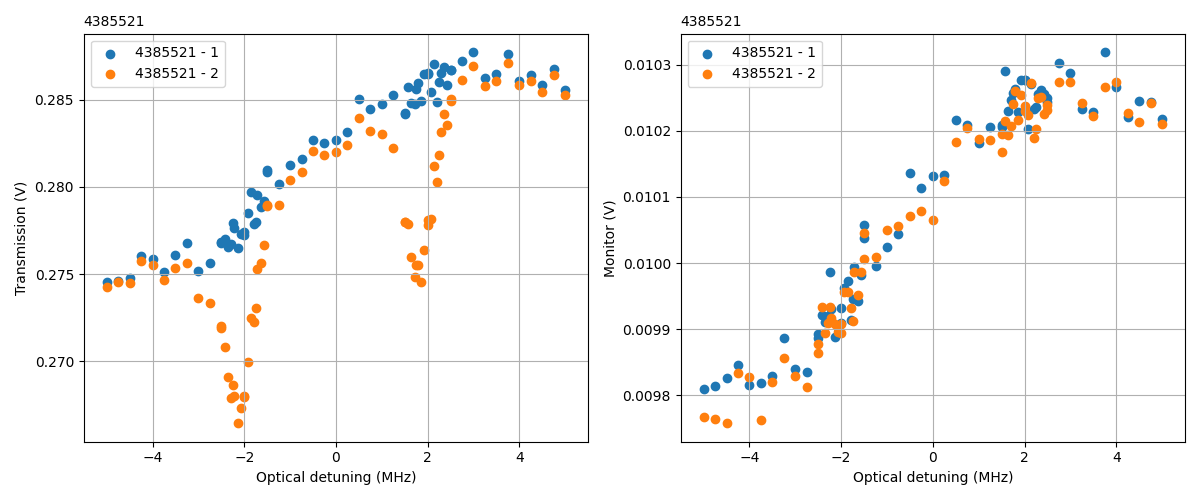

In [39]:
plot_raw_data(4385521)

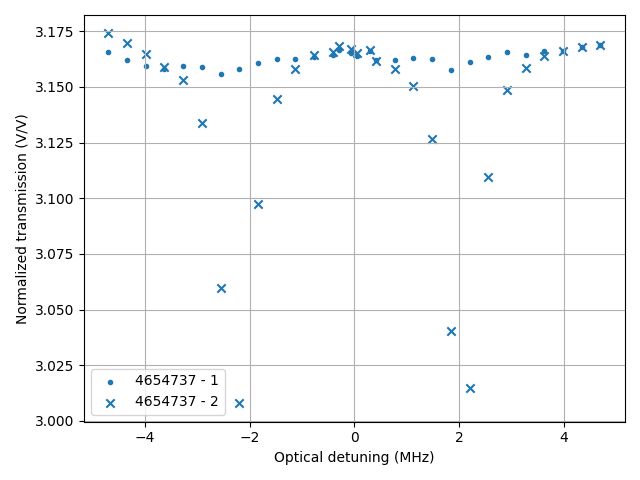

In [18]:
plot_antihole_data(4654737, od=False, normalize=True)

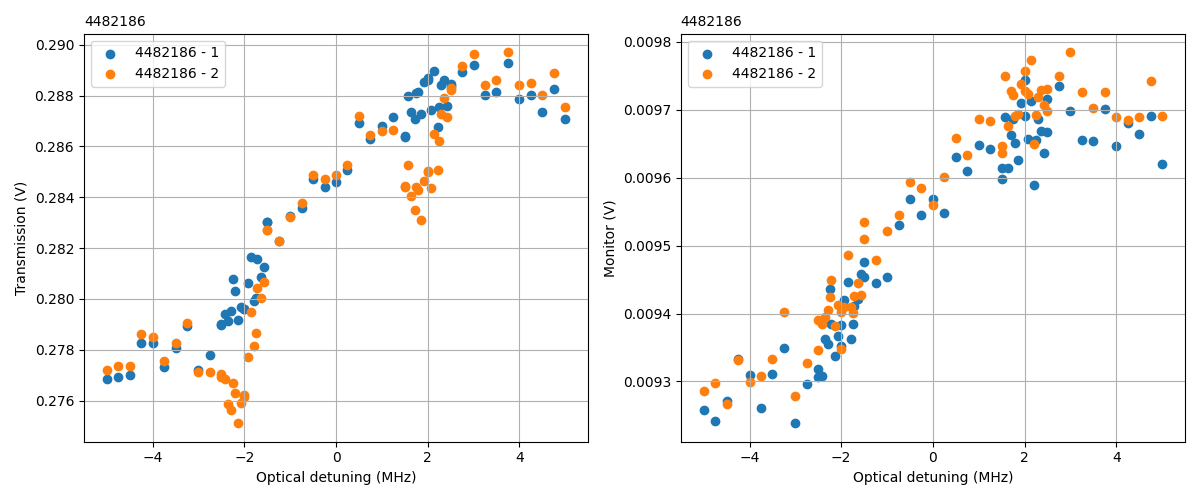

In [9]:
plot_raw_data(4482186)

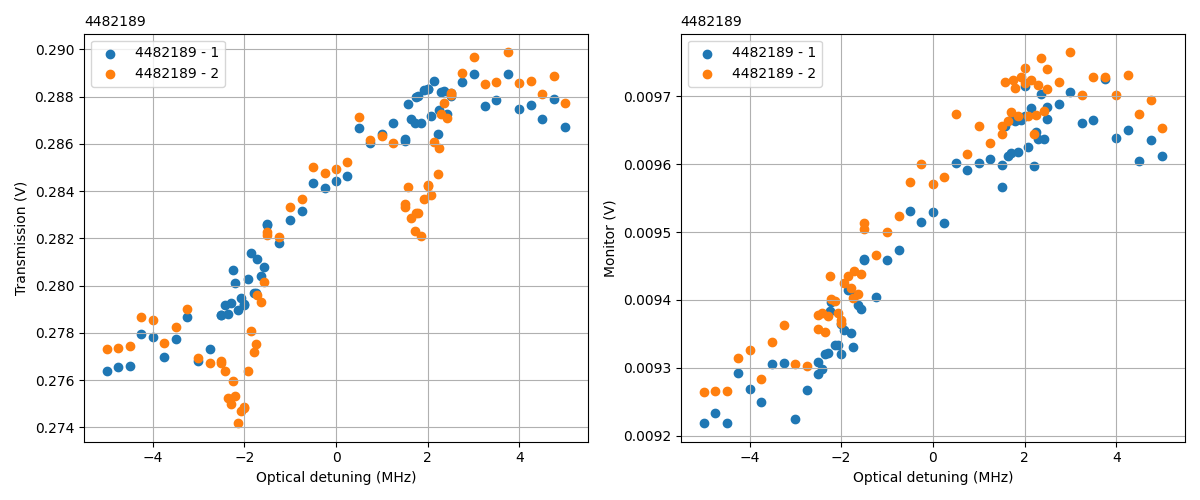

In [10]:
plot_raw_data(4482189)

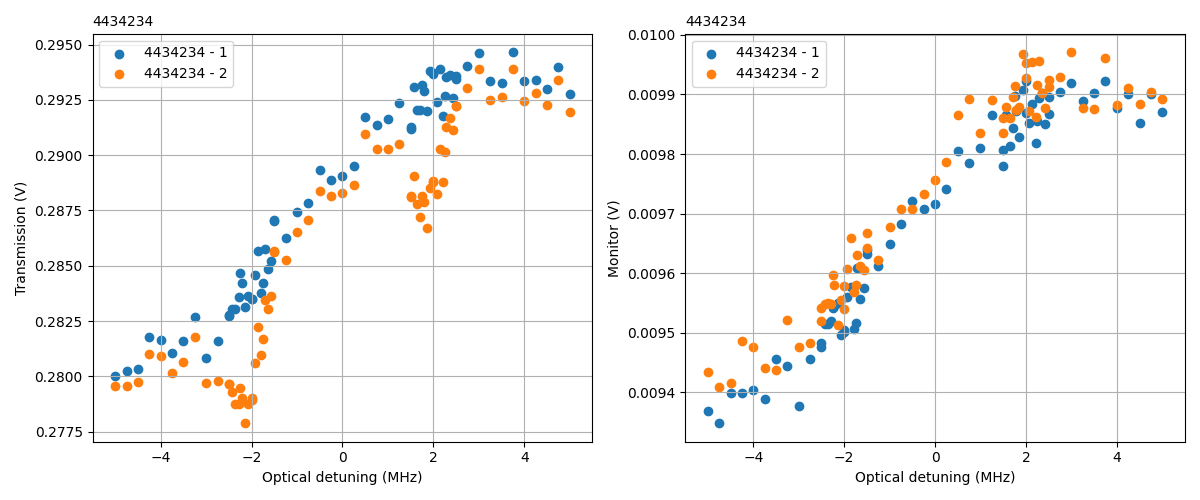

In [33]:
plot_raw_data((4482189 + 4386279) // 2 + 0)

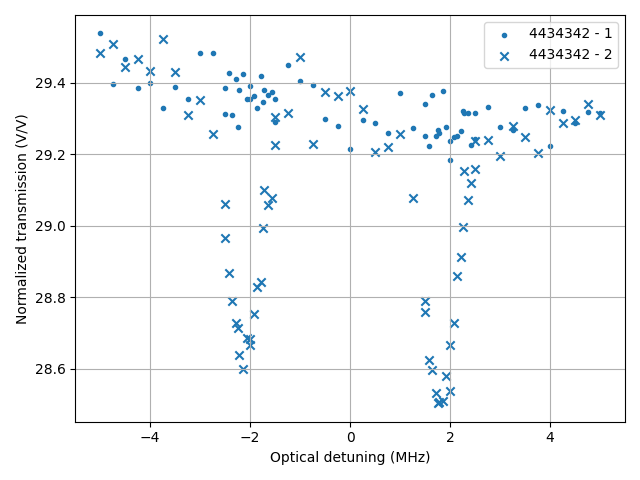

In [37]:
plot_antihole_data((4482189 + 4386279) // 2 + 108)

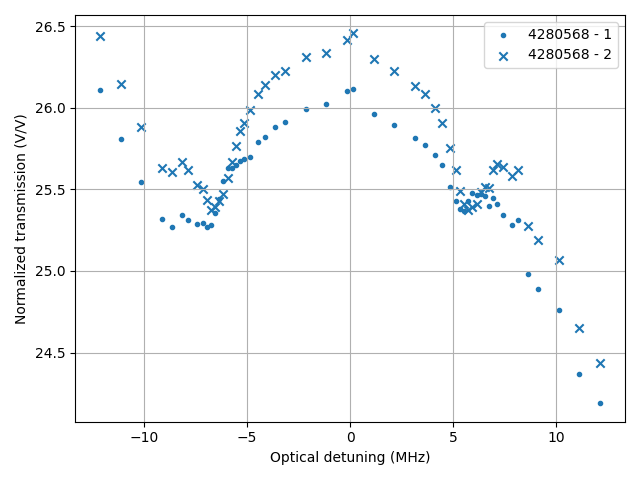

In [31]:
plot_antihole_data(4280568)

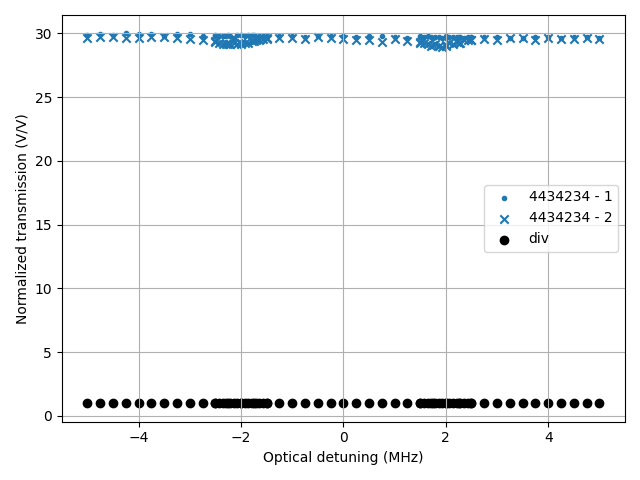

In [15]:
plot_antihole_data((4482189 + 4386279) // 2, divide_first_two = True)

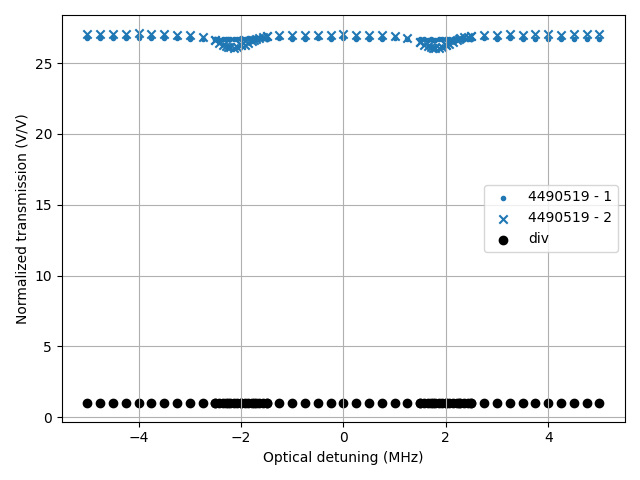

In [27]:
plot_antihole_data(4490519, divide_first_two = True) # weekend data with 200 detect amp

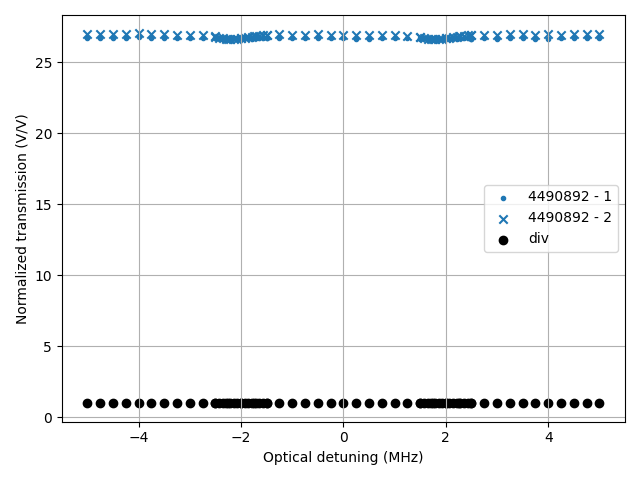

In [30]:
plot_antihole_data(4490892, divide_first_two = True) # weekend data with 200 detect amp, steady state 

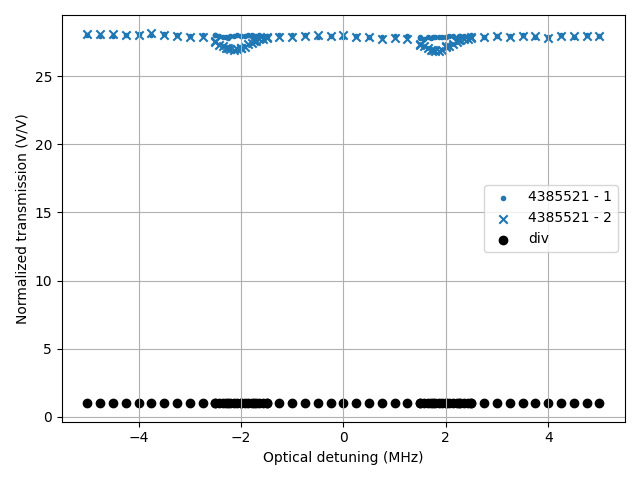

In [28]:
plot_antihole_data(4385521, divide_first_two = True)

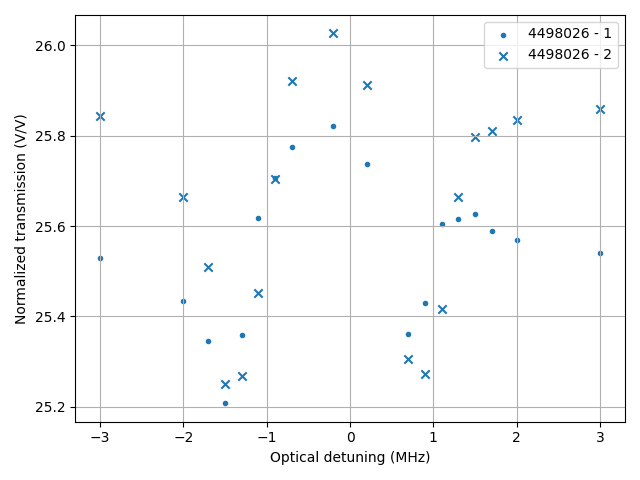

In [71]:
plot_antihole_data(4498026)

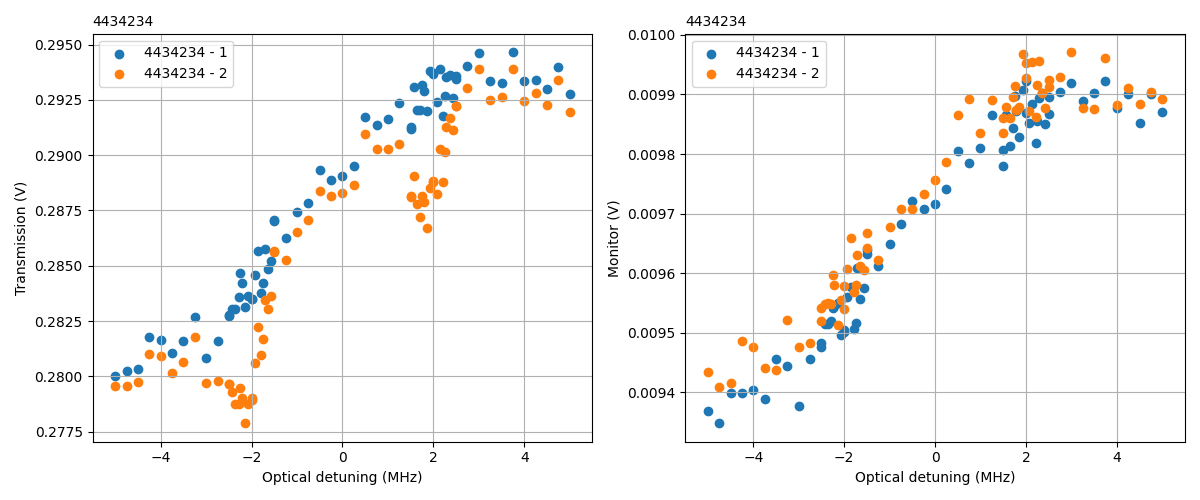

In [73]:
plot_raw_data((4482189 + 4386279) // 2)

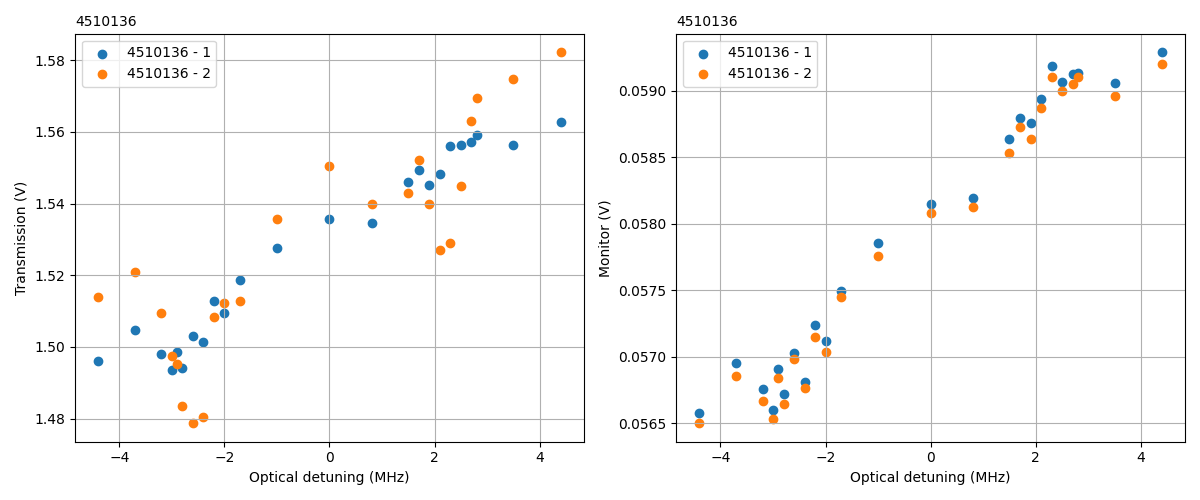

In [89]:
plot_raw_data(4510136)

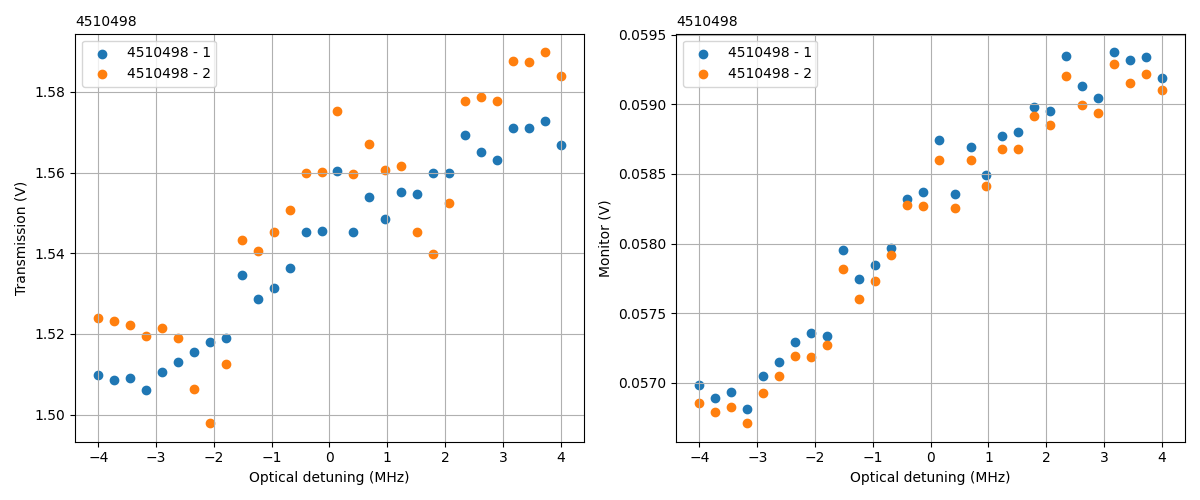

In [97]:
plot_raw_data(4510498) 

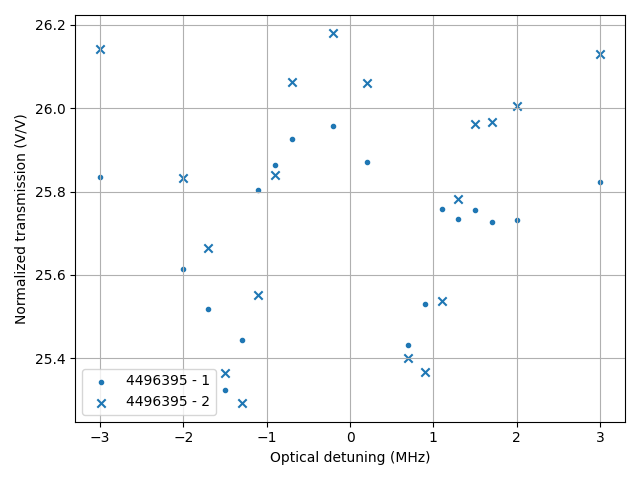

In [69]:
plot_antihole_data(4496395)

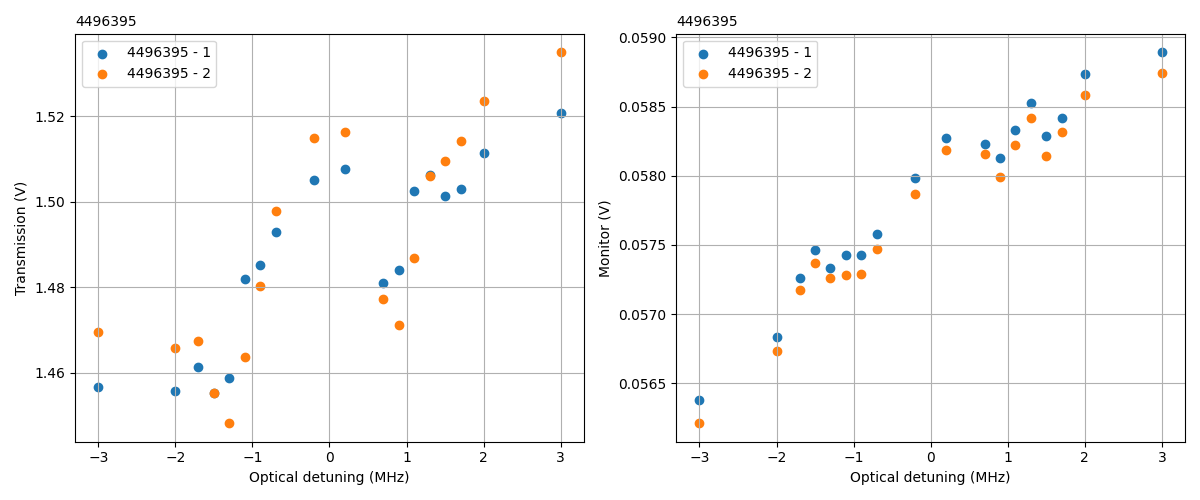

In [70]:
plot_raw_data(4496395)

In [48]:
print_data_number(4613690)

params: 
    name: Simple LF Spectroscopy Quick State Prep
    sequence_repeats_per_transfer: 1
    data_transfer_repeats: 1
    ao: 
        center_frequency: 80 megahertz
        name: ao_dp
        order: 2
        rise_delay: 1.1 microsecond
        fall_delay: 0.6 microsecond
    optical: 
        ao_amplitude: 2000
        cb_detuning: -18 megahertz
        use_mirror_cb: False
    chasm: 
        scan: 5 megahertz
        durations: 5 millisecond
        ao_amplitude: 2000
        transitions: ['bb']
        repeats: 20
        detunings: 0 megahertz
    detect: 
        transition: ac
        detunings: [-3.0 -2.0 -1.7 -1.5 -1.3 -1.1 -0.9 -0.7 -0.2 0.2 0.7 0.9 1.1 1.3 1.5 1.7 2.0 3.0] megahertz
        on_time: 100 microsecond
        off_time: 2 microsecond
        delay: 8 microsecond
        ao_amplitude: 200
        simultaneous: False
        name: digitizer
        randomize: False
        cycles: 
            1: 32
            2: 32
    rf: 
        HSH: 
            use

In [19]:
compare_experiments(4654737, 4654741)

field_plate amplitude: 4500 	 -4500


Text(0, 0.5, 'Measured $W_T$ (Hz) in 1.25 hours')

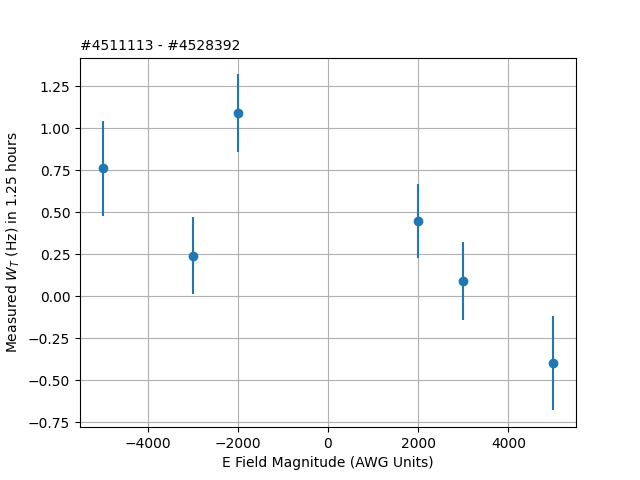

In [42]:
e_fields = [-2000, 2000, -3000, 3000, -5000, 5000]
W_T = [1.09, 0.45, 0.24, 0.09, 0.76, -0.40]
W_T_err = [0.23, 0.22, 0.23, 0.23, 0.28, 0.28]
start = 4511113 
end = 4528392
fig, ax = plt.subplots()
ax.errorbar(e_fields, W_T, yerr = W_T_err, fmt = "o", ls = "")
ax.grid()
ax.text(0,1.02,f"#{start} - #{end}", transform = ax.transAxes)
ax.set_xlabel("E Field Magnitude (AWG Units)")
ax.set_ylabel("Measured $W_T$ (Hz) in 1.25 hours")

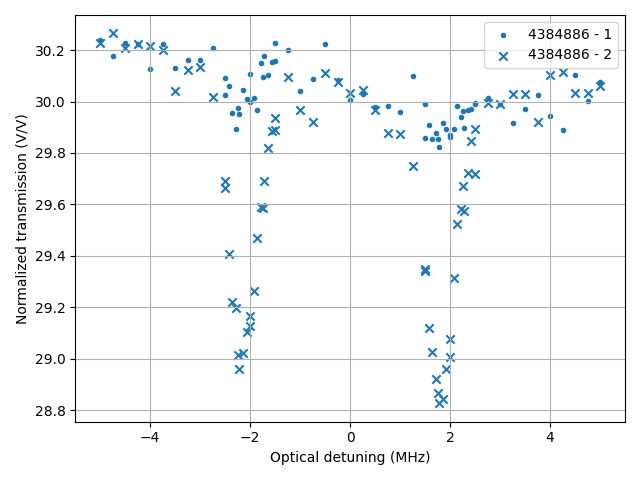

In [6]:
plot_antihole_data(4384886, errors = False, od = False, normalize = True)